# ARIMA

* Autoregressive Integrated Moving Average (ARIMA) is a commonly-used local statistical algorithm for time-series forecasting. ARIMA captures standard temporal structures (patterned organizations of time) in the input dataset.
* Autoregressive integrated moving average (ARIMA) models were popularised by Box and Jenkins (1970). 
* An ARIMA model describes a univariate time series as a combination of autoregressive (AR) and moving average (MA) lags which capture the autocorrelation within the time series. The order of integration denotes how many times the series has been differenced to obtain a stationary series.
* We write an ARIMA(p,d,q) model for some time series data yt, where p is the number of autoregressive lags, d is the degree of differencing and q is the number of moving average lags

ARIMA models are associated with a Box-Jenkins approach to time series. According to this approach:
1. Difference the series until it is stationary
2. Use the information criteria and autocorrelation plots to choose the appropriate lag order for an ARIMA process. 
3. Apply inference to obtain latent variable estimates, and check the model to see whether the model has captured the autocorrelation in the time series. For example, plot the autocorrelation of the model residuals. 
4. Finally, the model is used for retrospection and forecasting.

### Import the Dependencies

In [1]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller
from numpy import log
import numpy as np
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
import matplotlib as mpl
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.graphics.tsaplots as sgt

In [2]:
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
SARIMAX = sm.tsa.statespace.SARIMAX
import warnings
warnings.filterwarnings("ignore")

### Import the data

In [3]:
df = pd.read_pickle('Timeseries_data.pkl')

In [4]:
df.head()

,Date,Weighted_price
0,2012-04-02,136.312065
1,2012-04-03,137.683837
2,2012-04-04,136.686676
3,2012-04-09,133.772242
4,2012-04-10,133.975702


In [4]:
df = df.set_index('Date')

### Outlier Treatment

When we plot prices against time, it's observed that the markets went haywire in 2020 - due to the COVID crisis. 
Since, ARIMA is sensitive to such outliers we go ahead and remove them. 

1. Remove the outlier i.e. 2020
2. Convert the data to daily frequency
3. Fill all blanks including the time period we removed with a backfill i.e. with the previous days price.

<AxesSubplot:xlabel='Date'>

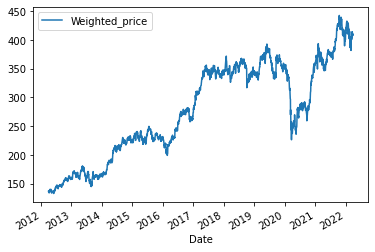

In [8]:
df.plot()

In [5]:
df.drop(df.loc['2020-01-01':'2020-12-31'].index, inplace=True) #remove 2020
df = df.asfreq('D') #set data frequency as daily
df = df.fillna(method='bfill') #fill all NaN's with previous value

<AxesSubplot:xlabel='Date'>

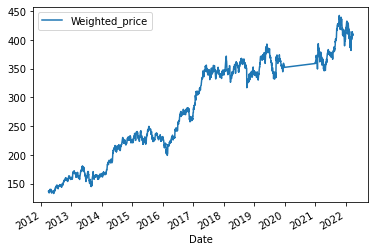

In [8]:
df.plot()

### Decomposition

A time series consists of four components. Variation of those components causes the change in the pattern of the time series. These components are:

* Level: It is the main value that goes on average with time.
* Trend: The trend is the value that causes increasing or decreasing patterns in a time series.
* Seasonality: This is a cyclic event that occurs in time series for a short time and causes the increasing or decreasing patterns for a short time in a time series.
* Noise: These are the random variations in the time series.

The combination of those components with time causes the formation of a time series. Most time series consists of the level and noise/residual and the trend or seasonality are the optional values. They may take part or they may not. 

If seasonality and trend are part of the time series then there will be effects in the forecast value. As the pattern of the forecasted time series can be different from the older time series.

The combination of the components in time series can be of two types:

1. Additive
1. Multiplicative

**Additive time series**

If the components of the time series are added together to make the time series it's called the additive time series. The mathematical function of any additive time series can be represented by:

`y(t) = level + Trend + seasonality + noise`

**Multiplicative time series**

If the components of the time series are multiplicative together, then the time series is called the multiplicative time series. The time series is having exponential growth or decrement with time then the time series can be considered as the multiplicative time series. The mathematical function of the Multiplicative time series is represented by:

`y(t) = Level * Trend * seasonality * Noise`

In [11]:
def decomposition_plot(ts):
# Apply seasonal_decompose 
    decomposition = seasonal_decompose(ts, period =255)
    
# Get trend, seasonality, and residuals
    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid

# Plotting
    plt.figure(figsize=(12,8))
    plt.subplot(411)
    plt.plot(np.log(ts), label='Original', color='blue')
    plt.legend(loc='best')
    plt.subplot(412)
    plt.plot(trend, label='Trend', color='blue')
    plt.legend(loc='best')
    plt.subplot(413)
    plt.plot(seasonal,label='Seasonality', color='blue')
    plt.legend(loc='best')
    plt.subplot(414)
    plt.plot(residual, label='Residuals', color='blue')
    plt.legend(loc='best')
    plt.tight_layout()

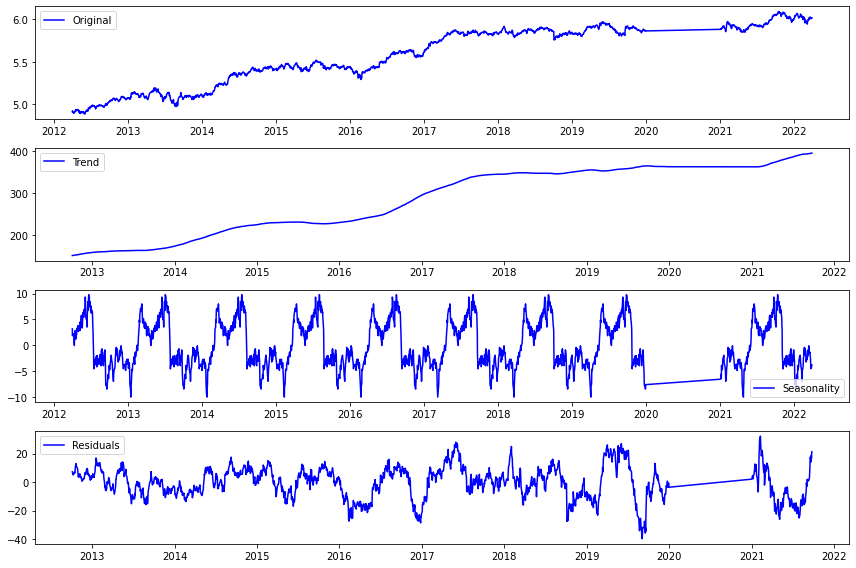

In [12]:
decomposition_plot(df.Weighted_price)

We can observe a time series with all four components present, therefore predicting this without transformations will not be accurate for us. 

On differencing we can see that most of these elements get mitigated, we will go ahead with the stationarity check on the basis of Unit Root statistical tests to confirm our transformations and proceed

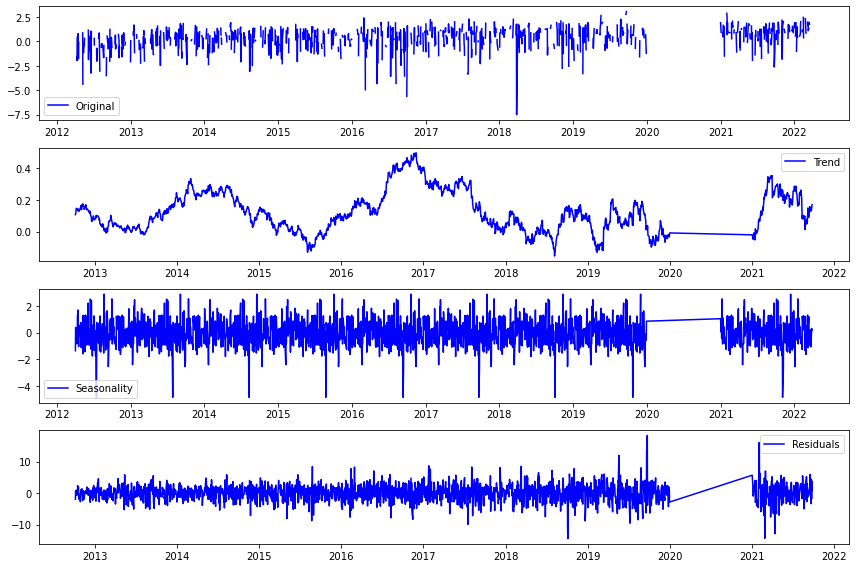

In [13]:
decomposition_plot(df.Weighted_price.diff().dropna())

### Test for Stationarity - ADF Test

In ARIMA time series forecasting, the first step is to determine the number of differencing required to make the series stationary. We test this using the Augmented-Dickey Fuller test i.e. ADF Test.

A stationary time series is one whose properties do not depend on the time at which the series is observed.Thus, time series with trends, or with seasonality, are not stationary — the trend and seasonality will affect the value of the time series at different times. On the other hand, a white noise series is stationary — it does not matter when you observe it, it should look much the same at any point in time.

The ADF test belongs to a category of tests called ‘Unit Root Test’, which is the proper method for testing the stationarity of a time series. The presence of a unit root means the time series is non-stationary. Besides, the number of unit roots contained in the series corresponds to the number of differencing operations required to make the series stationary.

The ADF test tests the following hypothesis:

H0: Unit Root exists. The series is non-stationary
H1: Unit Root does not exist, series is not stationary.

Therefore, if the given series is below 5% we agree that it is stationary. 

In [ ]:
result = adfuller(df['Weighted_price'].dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -1.090696
p-value: 0.718768


In [ ]:
result = adfuller(df['Weighted_price'].diff().dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -13.681237
p-value: 0.000000


In [ ]:
def stationarity_check(ts):
            
    # Calculate rolling statistics
    roll_mean = ts.rolling(window=8, center=False).mean()
    roll_std = ts.rolling(window=8, center=False).std()

    # Perform the Dickey Fuller test
    dftest = adfuller(ts) 
    
    # Plot rolling statistics:
    fig = plt.figure(figsize=(12,6))
    orig = plt.plot(ts, color='blue',label='Original')
    mean = plt.plot(roll_mean, color='red', label='Rolling Mean')
    std = plt.plot(roll_std, color='green', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    # Print Dickey-Fuller test results

    print('\nResults of Dickey-Fuller Test: \n')

    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', 
                                             '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

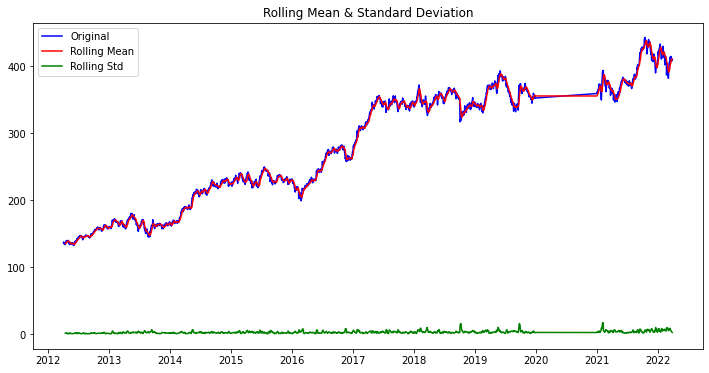


Results of Dickey-Fuller Test: 

Test Statistic                   -0.855533
p-value                           0.802263
#Lags Used                        2.000000
Number of Observations Used    2209.000000
Critical Value (1%)              -3.433314
Critical Value (5%)              -2.862849
Critical Value (10%)             -2.567467
dtype: float64


In [ ]:
stationarity_check(df.Weighted_price)

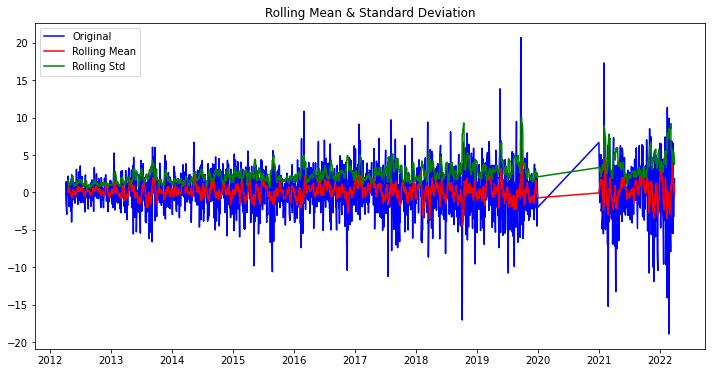


Results of Dickey-Fuller Test: 

Test Statistic                  -34.996891
p-value                           0.000000
#Lags Used                        1.000000
Number of Observations Used    2209.000000
Critical Value (1%)              -3.433314
Critical Value (5%)              -2.862849
Critical Value (10%)             -2.567467
dtype: float64


In [ ]:
stationarity_check(df.Weighted_price.diff().dropna())

We observe that stationarity is achieved at first differencing. 

`
The first difference of a time series is the series of changes from one period to the next. If Yt denotes the value of the time series Y at period t, then the first difference of Y at period t is equal to Yt-Yt-1
`

### Correlogram - ACF and PACF Graphs

A correlogram, also known as Auto Correlation Function (ACF) plot, is a graphic way to demonstrate serial correlation in data that doesn't remain constant with time. A correlogram gives a fair idea of auto-correlation between data pairs at different time periods. It's used as a tool to check randomness in a data set which is done by computing auto-correlations for data values at different time lags.

The auto-correlations are near zero for any time lag separation if it is random but if not, one or more of the auto-correlations will be non-zero.

The lags in the PACF and the ACF will respectively determine the AR and MA levels we will use in our models.

After using the differenced data we observe that the significant lags are 1 and 3

In [ ]:
def plot_acf_pacf(ts, figsize=(10,8),lags=24):
    
    fig,ax = plt.subplots(nrows=3, figsize=figsize)
    
    # Plot ts
    ts.plot(ax=ax[0])
    
    # Plot acf, pavf
    plot_acf(ts, ax=ax[1], lags=lags)
    plot_pacf(ts, ax=ax[2], lags=lags) 
    fig.tight_layout()
    
    for a in ax[1:]:
        a.xaxis.set_major_locator(mpl.ticker.MaxNLocator(min_n_ticks=lags, integer=True))
        a.xaxis.grid()
    return fig,ax

(<Figure size 720x576 with 3 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fa0fa931110>,
       dtype=object))

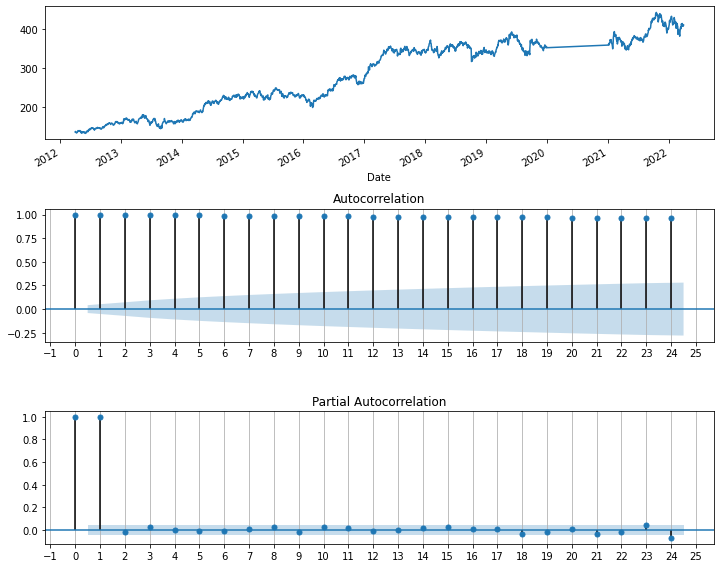

In [ ]:
plot_acf_pacf(df.Weighted_price)

(<Figure size 720x576 with 3 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fa0f5e51c90>,
       dtype=object))

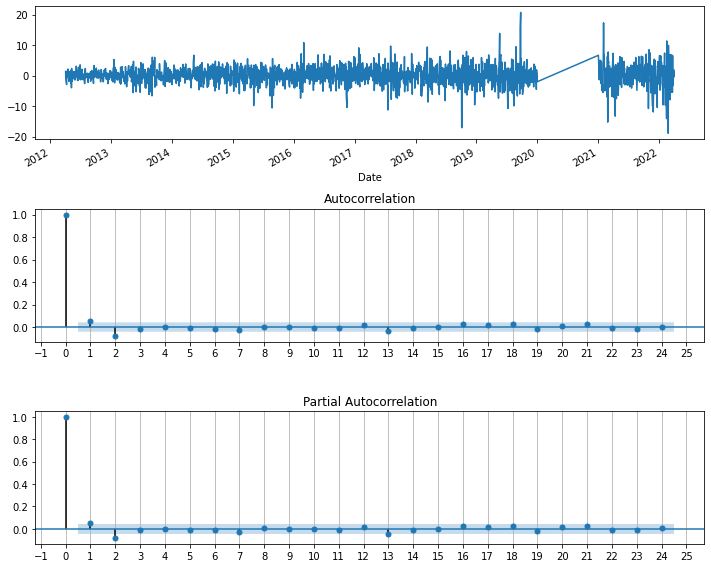

In [ ]:
plot_acf_pacf(df.Weighted_price.diff().dropna())

### Train-Test Split

The data is split into the training and testing datasets. Our model will be derived and trained using the train dataset and then we test the predicted values against the test data set to see how our model faired.

We have considered 70% of the data as our train and 30% as test. Since this is timeseries a random sample is not taken, instead we the the first 70% of the days to consider as train.

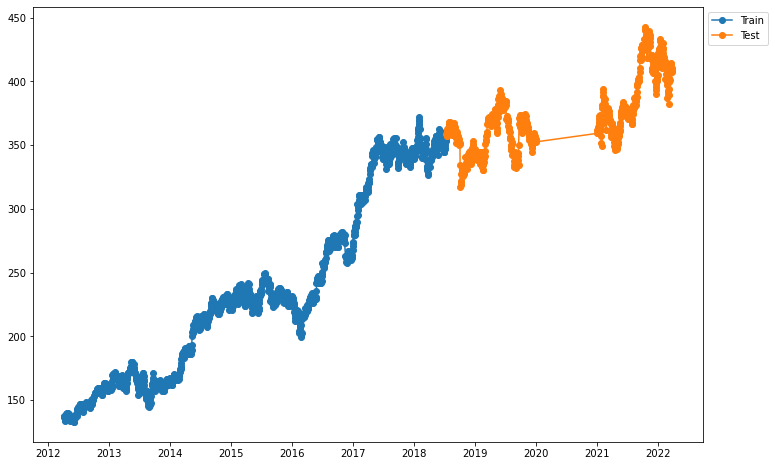

In [8]:
# Train Test Split Index
train_size = 0.7
split_idx = round(len(df)* train_size)
split_idx

# Split
train = df.iloc[:split_idx]
test = df.iloc[split_idx:]

# Visualize split
fig,ax= plt.subplots(figsize=(12,8))
kws = dict(marker='o')
plt.plot(train, label='Train', **kws)
plt.plot(test, label='Test', **kws)
ax.legend(bbox_to_anchor=[1,1]);

### Running ARIMA Models

Since we know our significant lags are 1 and 3, we run the following models

1. ARIMA (1,1,1)
2. ARIMA (1,1,3)
3. ARIMA (3,1,1)
4. ARIMA (3,1,3)

On the basis of the lowest AIC score, we select the best model. 

The Akaike information criterion (AIC) is an estimator of out-of-sample prediction error and thereby relative quality of statistical models for a given set of data. Given a collection of models for the data, AIC estimates the quality of each model, relative to each of the other models. AIC scores are only useful in comparison with other AIC scores for the same dataset. A lower AIC score is better.
AIC is calculated from:
* the number of independent variables used to build the model.
* the maximum likelihood estimate of the model (how well the model reproduces the data).

The best-fit model according to AIC is the one that explains the greatest amount of variation using the fewest possible independent variables.

In [ ]:
model_111 = ARIMA(train.Weighted_price, order=(1,1,1))
model_113 = ARIMA(train.Weighted_price, order=(1,1,3))
model_311 = ARIMA(train.Weighted_price, order=(3,1,1))
model_313 = ARIMA(train.Weighted_price, order=(3,1,3))

In [ ]:
model_111_fit = model_111.fit()
#model_113_fit = model_113.fit()
model_311_fit = model_311.fit()
model_313_fit = model_313.fit()

Model with order 1,1,3 could not be fit with this data.

In [ ]:
from tabulate import tabulate
table = [['Order', 'AIC Score'],['111',model_111_fit.aic],
         ['311',model_311_fit.aic],['313',model_313_fit.aic]]
print(tabulate(table,'firstrow'))

  Order    AIC Score
-------  -----------
    111      7074.78
    311      7076.27
    313      7074.78


We observe that both 1,1,1 and 3,1,3 have the same AIC Scores. Therefore we plot a residual correlogram to check if there are any residual lags to further refine the model.
However, both models did have any residual lags

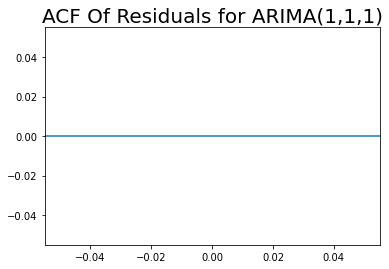

In [ ]:
train['res_arima_111'] = model_111_fit.resid
sgt.plot_acf(train.res_arima_111, zero = False, lags = 40)
plt.title("ACF Of Residuals for ARIMA(1,1,1)",size=20)
plt.show()

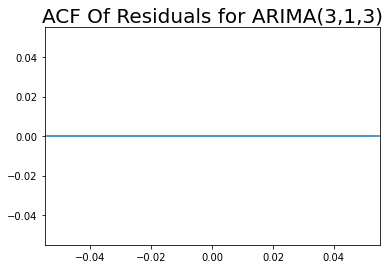

In [ ]:
train['res_arima_313'] = model_313_fit.resid
sgt.plot_acf(train.res_arima_313, zero = False, lags = 40)
plt.title("ACF Of Residuals for ARIMA(3,1,3)",size=20)
plt.show()

To investigate further, we look at the whole summary of the models and on this basis we can conclude that 3,1,3 is the better model and we proceed with this

In [ ]:
model_111_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:       D.Weighted_price   No. Observations:                 1547
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -3533.391
Method:                       css-mle   S.D. of innovations              2.375
Date:                Mon, 11 Jul 2022   AIC                           7074.782
Time:                        12:00:24   BIC                           7096.158
Sample:                             1   HQIC                          7082.733
                                                                              
==========================================================================================
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      0.1433      0.062      2.308      0.021       0.022       0.265
ar.L1.D.Weighted_price    -0.4691      0.437     -1.073      0.284      -1.326       0.388
ma.L1.D.Weighted_price     0.5106      0.426      1.199      0.231      -0.324       1.345
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -2.1317           +0.0000j            2.1317            0.5000
MA.1           -1.9584           +0.0000j            1.9584            0.5000
-----------------------------------------------------------------------------
"""

In [ ]:
model_313_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:       D.Weighted_price   No. Observations:                 1547
Model:                 ARIMA(3, 1, 3)   Log Likelihood               -3529.389
Method:                       css-mle   S.D. of innovations              2.369
Date:                Mon, 11 Jul 2022   AIC                           7074.778
Time:                        12:00:32   BIC                           7117.530
Sample:                             1   HQIC                          7090.680
                                                                              
==========================================================================================
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      0.1434      0.061      2.366      0.018       0.025       0.262
ar.L1.D.Weighted_price     0.6958      0.393      1.773      0.077      -0.074       1.465
ar.L2.D.Weighted_price     0.0309      0.537      0.058      0.954      -1.021       1.083
ar.L3.D.Weighted_price    -0.6745      0.361     -1.870      0.062      -1.382       0.033
ma.L1.D.Weighted_price    -0.6548      0.383     -1.712      0.087      -1.405       0.095
ma.L2.D.Weighted_price    -0.0736      0.511     -0.144      0.885      -1.075       0.927
ma.L3.D.Weighted_price     0.6820      0.338      2.017      0.044       0.019       1.345
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.7321           -0.7136j            1.0224           -0.1230
AR.2            0.7321           +0.7136j            1.0224            0.1230
AR.3           -1.4184           -0.0000j            1.4184           -0.5000
MA.1            0.7398           -0.7224j            1.0340           -0.1231
MA.2            0.7398           +0.7224j            1.0340            0.1231
MA.3           -1.3716           -0.0000j            1.3716           -0.5000
-----------------------------------------------------------------------------
"""

Model 313 is slightly better

We then go on to run SARIMA models to detect the seasonal component in our data.
We check for seasonality in the intervals of 
1. 7 Days - Weekly
2. 15 Days - Bi-weekly
3. 30 Days - Monthly

On the basis of which gives us the least AIC score we can proceed.

In [ ]:
model_sarima_7 = SARIMAX(train.Weighted_price, order=(1,1,1), seasonal_order = (3,1,3,7))
results_sarima_7 = model_sarima_7.fit()
results_sarima_7.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                
=========================================================================================
Dep. Variable:                    Weighted_price   No. Observations:                 1548
Model:             SARIMAX(1, 1, 1)x(3, 1, 3, 7)   Log Likelihood               -3535.297
Date:                           Mon, 11 Jul 2022   AIC                           7088.593
Time:                                   12:05:29   BIC                           7136.649
Sample:                                        0   HQIC                          7106.472
                                          - 1548                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6138      0.318     -1.933      0.053      -1.236       0.009
ma.L1          0.6512      0.305      2.137      0.033       0.054       1.248
ar.S.L7       -1.1090      0.280     -3.957      0.000      -1.658      -0.560
ar.S.L14      -0.5450      0.271     -2.012      0.044      -1.076      -0.014
ar.S.L21      -0.0563      0.027     -2.113      0.035      -0.109      -0.004
ma.S.L7        0.1152      0.279      0.413      0.679      -0.431       0.662
ma.S.L14      -0.5968      0.185     -3.224      0.001      -0.960      -0.234
ma.S.L21      -0.5110      0.277     -1.842      0.065      -1.055       0.033
sigma2         5.6447      0.172     32.790      0.000       5.307       5.982
===================================================================================
Ljung-Box (Q):                       53.36   Jarque-Bera (JB):               225.71
Prob(Q):                              0.08   Prob(JB):                         0.00
Heteroskedasticity (H):               2.58   Skew:                            -0.20
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.83
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
model_sarima_15 = SARIMAX(train.Weighted_price, order=(1,1,1), seasonal_order = (3,1,3,15))
results_sarima_15 = model_sarima_15.fit()
results_sarima_15.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                     Weighted_price   No. Observations:                 1548
Model:             SARIMAX(1, 1, 1)x(3, 1, 3, 15)   Log Likelihood               -3530.811
Date:                            Mon, 11 Jul 2022   AIC                           7079.622
Time:                                    12:08:43   BIC                           7127.631
Sample:                                         0   HQIC                          7097.488
                                           - 1548                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5478      0.291     -1.881      0.060      -1.119       0.023
ma.L1          0.5938      0.279      2.127      0.033       0.047       1.141
ar.S.L15      -0.7979      0.106     -7.550      0.000      -1.005      -0.591
ar.S.L30      -0.8846      0.097     -9.090      0.000      -1.075      -0.694
ar.S.L45      -0.0186      0.027     -0.683      0.495      -0.072       0.035
ma.S.L15      -0.2135      0.148     -1.438      0.150      -0.504       0.077
ma.S.L30       0.1158      0.133      0.871      0.384      -0.145       0.377
ma.S.L45      -0.8984      0.133     -6.740      0.000      -1.160      -0.637
sigma2         5.6263      0.628      8.963      0.000       4.396       6.857
===================================================================================
Ljung-Box (Q):                       54.10   Jarque-Bera (JB):               243.11
Prob(Q):                              0.07   Prob(JB):                         0.00
Heteroskedasticity (H):               2.60   Skew:                            -0.19
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.91
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [9]:
model_sarima_30 = SARIMAX(train.Weighted_price, order=(1,1,1), seasonal_order = (3,1,3,30))
results_sarima_30 = model_sarima_30.fit()
results_sarima_30.summary()

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.35707D+00    |proj g|=  1.29831D-01

At iterate    5    f=  2.27923D+00    |proj g|=  3.76213D-02

At iterate   10    f=  2.27429D+00    |proj g|=  4.63307D-03

At iterate   15    f=  2.27408D+00    |proj g|=  4.97914D-04

At iterate   20    f=  2.27405D+00    |proj g|=  3.51832D-03

At iterate   25    f=  2.27338D+00    |proj g|=  1.41917D-02

At iterate   30    f=  2.27257D+00    |proj g|=  3.35303D-02

At iterate   35    f=  2.27241D+00    |proj g|=  3.81815D-03

At iterate   40    f=  2.27240D+00    |proj g|=  3.47719D-04

At iterate   45    f=  2.27234D+00    |proj g|=  1.95275D-02

At iterate   50    f=  2.27232D+00    |proj g|=  2.24581D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

<class 'statsmodels.iolib.summary.Summary'>
"""
                                         SARIMAX Results                                          
==================================================================================================
Dep. Variable:                             Weighted_price   No. Observations:                 1548
Model:             SARIMAX(1, 1, 1)x(3, 1, [1, 2, 3], 30)   Log Likelihood               -3517.544
Date:                                    Wed, 13 Jul 2022   AIC                           7053.089
Time:                                            18:43:59   BIC                           7101.009
Sample:                                                 0   HQIC                          7070.931
                                                   - 1548                                         
Covariance Type:                                      opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4686      0.337     -1.390      0.164      -1.129       0.192
ma.L1          0.5156      0.326      1.584      0.113      -0.122       1.154
ar.S.L30      -1.1397      0.075    -15.100      0.000      -1.288      -0.992
ar.S.L60      -0.9343      0.074    -12.691      0.000      -1.079      -0.790
ar.S.L90       0.0186      0.031      0.600      0.548      -0.042       0.079
ma.S.L30       0.1887      3.578      0.053      0.958      -6.823       7.201
ma.S.L60      -0.2132      4.251     -0.050      0.960      -8.546       8.119
ma.S.L90      -0.9751      3.504     -0.278      0.781      -7.843       5.893
sigma2         5.5638     19.895      0.280      0.780     -33.430      44.557
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):               246.13
Prob(Q):                              0.86   Prob(JB):                         0.00
Heteroskedasticity (H):               2.59   Skew:                            -0.19
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.94
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

The SARIMA(3,1,3,30) Model gives us the best scores. Therefore we proceed with the same. 
We check for residual lags and only the 30th lag, i.e. the seasonal component we chose has it. Therefore, we finalise this model for our predictions.

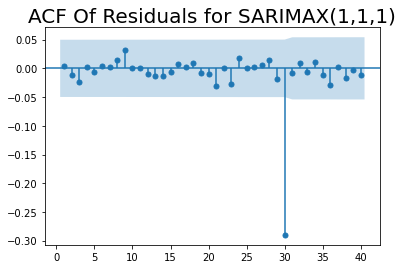

In [10]:
train['results_sarimax'] = results_sarima_30.resid.iloc[:]
sgt.plot_acf(train.results_sarimax, zero = False, lags = 40)
plt.title("ACF Of Residuals for SARIMAX(1,1,1)",size=20)
plt.show()

### Test Predictions

Predictions based on the SARIMA(3,1,3,30) model for the next 30% of the days are made and compared with the original prices form test data. We also get a confidence interval of 95% values on either side to check. 

In [11]:
pred_array = results_sarima_30.get_forecast(steps=len(test))

In [12]:
pred_df = pd.DataFrame()

In [13]:
pred_df['pred'] = pred_array.predicted_mean

In [14]:
temp = pred_array.conf_int()

In [15]:
pred_df['lower'] = temp['lower Weighted_price']
pred_df['upper'] = temp['upper Weighted_price']

In [16]:
pred_df = pred_df.set_index(test.index)

In [17]:
# Plotting Predictions
def plot_train_test_pred(train,test,pred_df):
    fig,ax = plt.subplots(figsize=(12,7))
    kws = dict(marker='o')
    
    ax.plot(train,label='Train',**kws)
    ax.plot(test,label='Test',**kws)
    ax.plot(pred_df['pred'],label='Prediction',ls='--',linewidth=3)

    ax.fill_between(x=pred_df.index,y1=pred_df['lower'],y2=pred_df['upper'],alpha=0.3)
    ax.set_title('Model Validation', fontsize=22)
    ax.legend(loc='upper left')
    fig.tight_layout()
    return fig,ax

In [18]:
train = train.drop('results_sarimax',axis=1)

(<Figure size 864x504 with 1 Axes>,
 <AxesSubplot:title={'center':'Model Validation'}>)

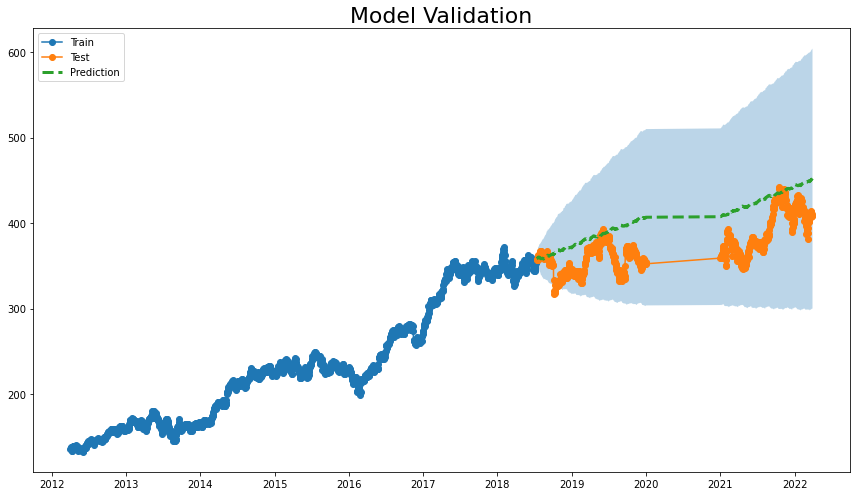

In [19]:
plot_train_test_pred(train,test,pred_df)

Here we observe that most of our actual test values are within the confidence interval of the ARIMA predictions

### Forecast the next 30 days

We then forecast for the next 30 days to eventually compare it to the actual prices.

In [20]:
def forecast_to_df(model, steps=12):
    forecast = model.get_forecast(steps=steps)
    forecast_df = forecast.conf_int()
    forecast_df['pred'] = forecast.predicted_mean
    forecast_df['Date'] = pd.date_range('2022-04-01', periods=steps)
    forecast_df = forecast_df.set_index('Date')
    forecast_df.columns = ['lower', 'upper', 'pred']
    return forecast_df

In [21]:
forecast_df = forecast_to_df(results_sarima_30, steps = 30)

In [22]:
# Plotting Predictions
def plot_forecast(df,forecast_df):
    fig,ax = plt.subplots(figsize=(12,7))
    kws = dict(marker='o')
    
    ax.plot(df,label='Train',**kws)
    ax.plot(forecast_df['pred'],label='Prediction',ls='--',linewidth=3)

    ax.fill_between(x=forecast_df.index,y1=forecast_df['lower'],y2=forecast_df['upper'],alpha=0.3)
    ax.set_title('Model Validation', fontsize=22)
    ax.legend(loc='upper left')
    fig.tight_layout()
    return fig,ax

(<Figure size 864x504 with 1 Axes>,
 <AxesSubplot:title={'center':'Model Validation'}>)

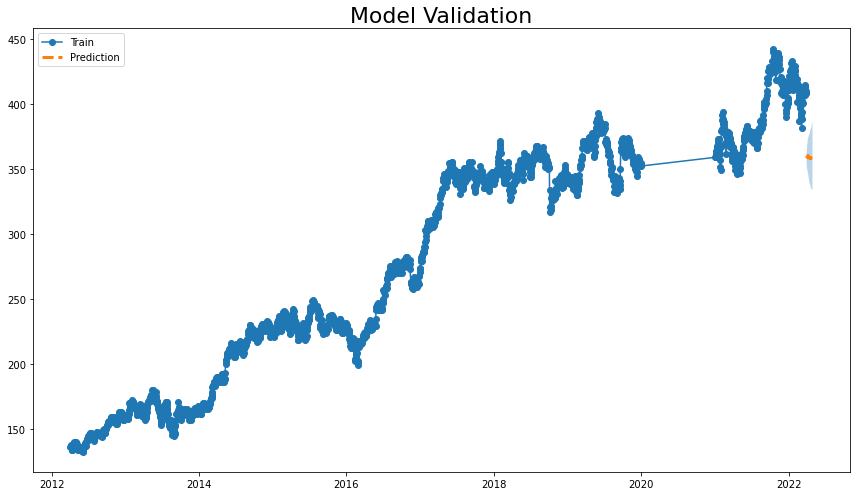

In [23]:
plot_forecast(df,forecast_df)

### Export the datasets

In [25]:
forecast_df.to_pickle('Forecast_ARIMA.pkl')
forecast_df.to_csv('Forecast_ARIMA.csv')

In [26]:
pred_df.to_csv('Predicted_ARIMA.csv')